In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 19 14:00:07 2024

@author: ADM
"""



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import (
    DBSCAN,
    KMeans,
    AgglomerativeClustering,
    MeanShift,
)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    rand_score,
    fowlkes_mallows_score,
)

# custom
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import util
from class_manipulates_path import ManipulatePath
from class_preprocessing_refactor import Preprocessing
from class_format_data import FormatData
util.init()


def split_dataframe(df, target_column=None, test_size=0.0003, random_state=42):
    if target_column:
        # Se a coluna alvo for fornecida, realizar a divisão estratificada
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        for train_index, test_index in split.split(df, df[target_column]):
            df_1 = df.iloc[train_index]
            df_2 = df.iloc[test_index]
    else:
        # Se a coluna alvo não for fornecida, realizar a divisão simples
        df_1, df_2 = train_test_split(df, test_size=test_size, random_state=random_state)

    return df_1, df_2

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Load custom Data Set
manipulate_path = ManipulatePath()

preprocessing = Preprocessing()

format_data = FormatData()

path_raw_data = manipulate_path.get_path_raw_data()

df_preprocessing = pd.read_parquet(manipulate_path.get_path_preprocessing_real_data_all_classes())

df_1, df_2 = split_dataframe(df_preprocessing, target_column='class')


# aplicando PCA
n_components = 2
pca = PCA(n_components=n_components)
scaler = StandardScaler()
X = scaler.fit_transform(df_2.drop(columns="class"))
X_pca = pca.fit_transform(X)
list_comp = [f"COMP_{x+1}"  for x in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=list_comp)
df_pca["class"] = df_2["class"].values
df_2 = df_pca.copy()



X = df_2.iloc[:, :-1].values

y = df_2.iloc[:, -1].values

# Declare an empty DataFrame with the required columns
pred_df = pd.DataFrame(columns=["Algorithm", "Metric", "Score"])


# Algorithm                                     Best Params  Silhouette Score
# 0           K-Means           {'n_clusters': 4, 'random_state': 42}          0.740233
# 1      Hierarchical            {'linkage': 'ward', 'n_clusters': 4}          0.740233
# 2  Gaussian Mixture  {'covariance_type': 'tied', 'n_components': 4}          0.738205
# 3        Mean Shift                             {'bandwidth': None}          0.740233

# Implement clustering algorithms
dbscan = DBSCAN(eps=0.5, min_samples=5)
kmeans = KMeans(n_clusters=4, random_state=42)
agglo = AgglomerativeClustering(linkage="ward", n_clusters= 4)
gmm = GaussianMixture(covariance_type= 'tied', n_components= 4)
ms = MeanShift()

# Evaluate clustering algorithms with three evaluation metrics
labels = {
    "DBSCAN": dbscan.fit_predict(X),
    "K-Means": kmeans.fit_predict(X),
    "Hierarchical": agglo.fit_predict(X),
    "Gaussian Mixture": gmm.fit_predict(X),
    "Mean Shift": ms.fit_predict(X),
}

metrics = {
    "Silhouette Score": silhouette_score,
    "Calinski Harabasz Score": calinski_harabasz_score,
    "Davies Bouldin Score": davies_bouldin_score,
    "Rand Score": rand_score,
    "Fowlkes-Mallows Score": fowlkes_mallows_score,
}

results = []



c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2]:
for name, label in labels.items():
    for metric_name, metric_func in metrics.items():
        if metric_name in ["Rand Score", "Fowlkes-Mallows Score"]:
            score = metric_func(y, label)
        else:
            if len(np.unique(label)) != 1:
                score = metric_func(X, label)
            else:
                score = -1
        results.append({"Algorithm": name, "Metric": metric_name, "Score": score})

pred_df = pd.concat([pred_df, pd.DataFrame(results)], ignore_index=True)

# Display the DataFrame
print(pred_df.head(10))

  Algorithm                   Metric        Score
0    DBSCAN         Silhouette Score     0.743581
1    DBSCAN  Calinski Harabasz Score  1261.945748
2    DBSCAN     Davies Bouldin Score     0.458652
3    DBSCAN               Rand Score     0.734160
4    DBSCAN    Fowlkes-Mallows Score     0.494986
5   K-Means         Silhouette Score     0.718606
6   K-Means  Calinski Harabasz Score  1037.952129
7   K-Means     Davies Bouldin Score     0.445188
8   K-Means               Rand Score     0.729284
9   K-Means    Fowlkes-Mallows Score     0.510895


In [3]:
pred_df

,Algorithm,Metric,Score
0,DBSCAN,Silhouette Score,0.743581
1,DBSCAN,Calinski Harabasz Score,1261.945748
2,DBSCAN,Davies Bouldin Score,0.458652
3,DBSCAN,Rand Score,0.734160
4,DBSCAN,Fowlkes-Mallows Score,0.494986
5,K-Means,Silhouette Score,0.718606
6,K-Means,Calinski Harabasz Score,1037.952129
7,K-Means,Davies Bouldin Score,0.445188
8,K-Means,Rand Score,0.729284
9,K-Means,Fowlkes-Mallows Score,0.510895


In [4]:
df_2

,COMP_1,COMP_2,class
0,1.759266,-0.264924,5.0
1,1.700476,-0.743121,0.0
2,-1.484622,0.093381,0.0
3,1.243624,1.491169,5.0
4,-1.780959,0.541650,7.0
...,...,...,...
289,-0.787193,-1.290216,1.0
290,1.418101,1.362249,5.0
291,-0.793187,-1.309228,1.0
292,-1.341888,-0.373958,1.0


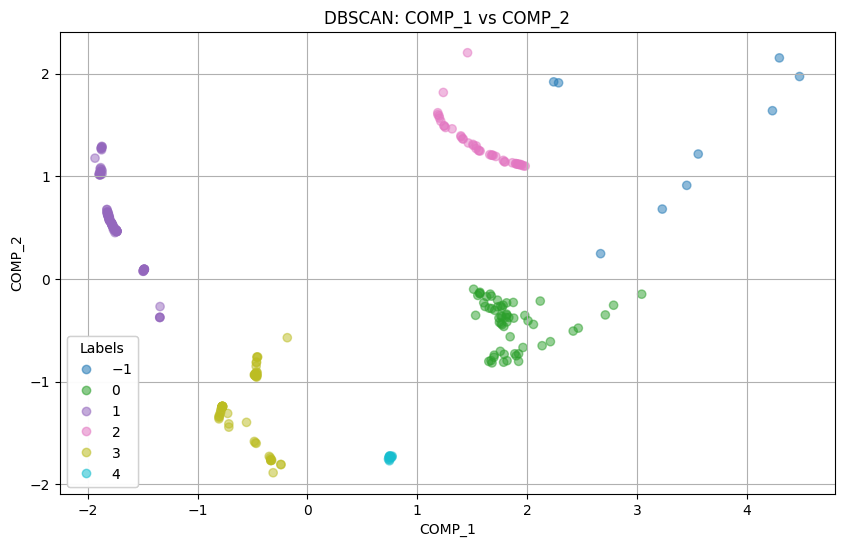

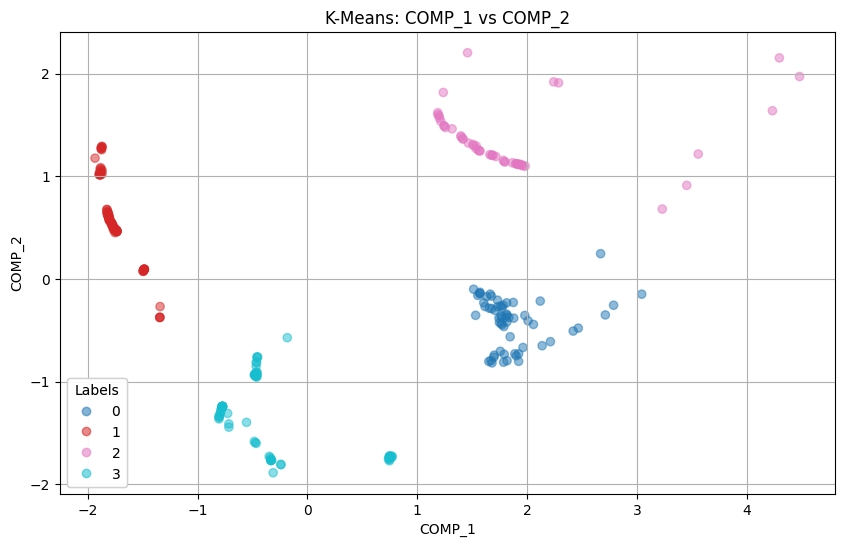

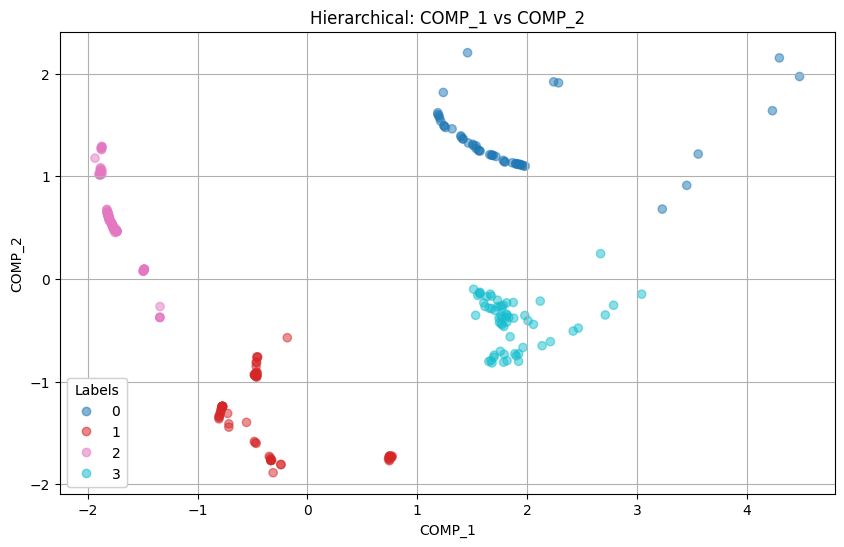

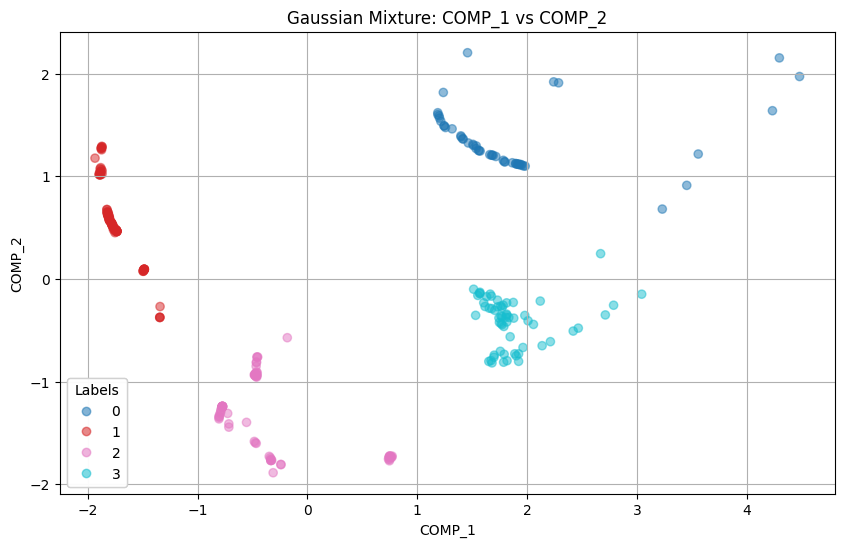

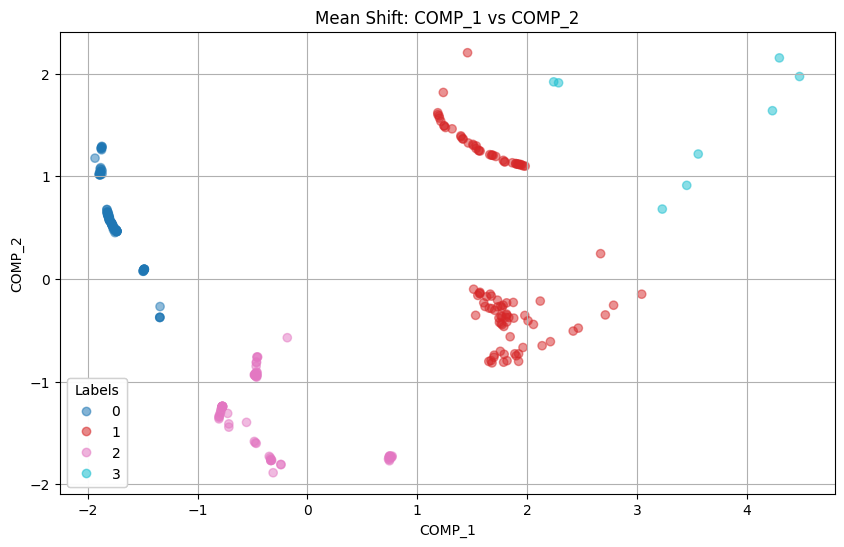

In [5]:

var1 = "P-TPT"
var2 = "T-TPT"

var1 = "COMP_1"
var2 = "COMP_2"

for model_name, label in labels.items():
    # Plota os pontos
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df_2[var1], df_2[var2], c=label, cmap='tab10', alpha=0.5)
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'{model_name}: {var1} vs {var2}')
    plt.grid(True)
    
    legend1 = plt.legend(*scatter.legend_elements(), title="Labels")
    plt.gca().add_artist(legend1)
    
    plt.show()

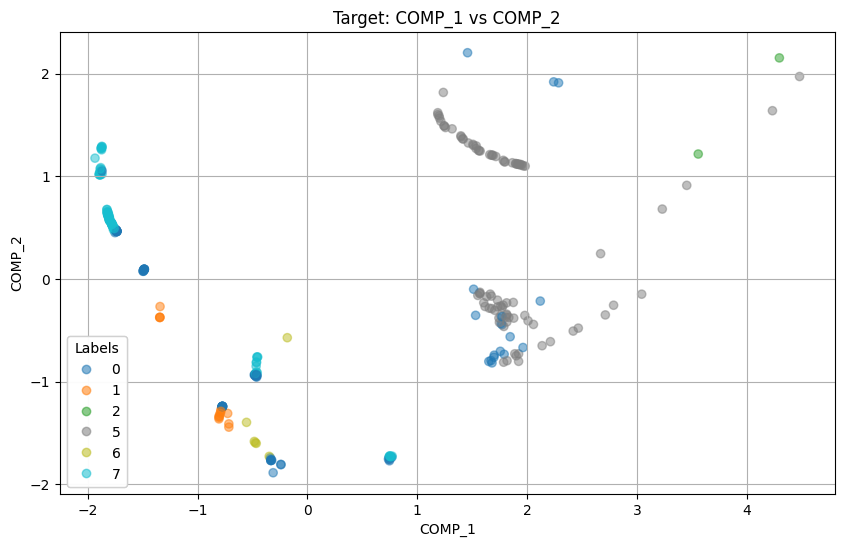

In [6]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_2[var1], df_2[var2], c=y, cmap='tab10', alpha=0.5)
plt.xlabel(var1)
plt.ylabel(var2)
plt.title(f'Target: {var1} vs {var2}')
plt.grid(True)

legend1 = plt.legend(*scatter.legend_elements(), title="Labels")
plt.gca().add_artist(legend1)

plt.show()